In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv("./data_paper/Force15kgf.csv")
data.head()

,Unnamed: 0,Cycle,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS (dt),CVES (dt),DIV,DVSOC50,SOH
0,0,1,1357.5,1283.5,72.82119,2.4414,11.036,1.680,0.01614,0.000072,2.5081,3.2522,1.00000
1,1,2,1357.7,1285.9,72.41452,2.7008,11.118,1.590,0.02041,0.000160,2.5014,3.2517,1.00134
2,2,3,1357.7,1286.0,72.05853,2.7048,11.090,1.680,0.02021,0.000129,2.5023,3.2520,1.00188
3,3,4,1357.8,1286.5,71.75321,2.7065,11.042,1.636,0.01887,0.000146,2.5049,3.2520,1.00215
4,4,5,1357.9,1286.7,71.49856,2.7071,11.020,1.624,0.01857,0.000180,2.5057,3.2519,1.00202


In [3]:
print(data['Cycle'].max())

558


In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
def bisquare(x):
    x=abs(x)
    res=[]
    for v in x:
        if v<1:
            res.append((1-v**2)**2)
        else:
            res.append(0)
    return np.array(res)

def tricube(x):
    x=abs(x)
    res=[]
    for v in x:
        if v<1:
            res.append((1-v**3)**3)
        else:
            res.append(0)
    return np.array(res)

def get_n_th_distance(x,y,n):
    y=np.array(y)
    distance=abs(y-x)
    distance=np.sort(distance)
    return distance[n-1]


(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            WLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.202e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        07:08:19   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1095.9958     61.454     17.835      0.0

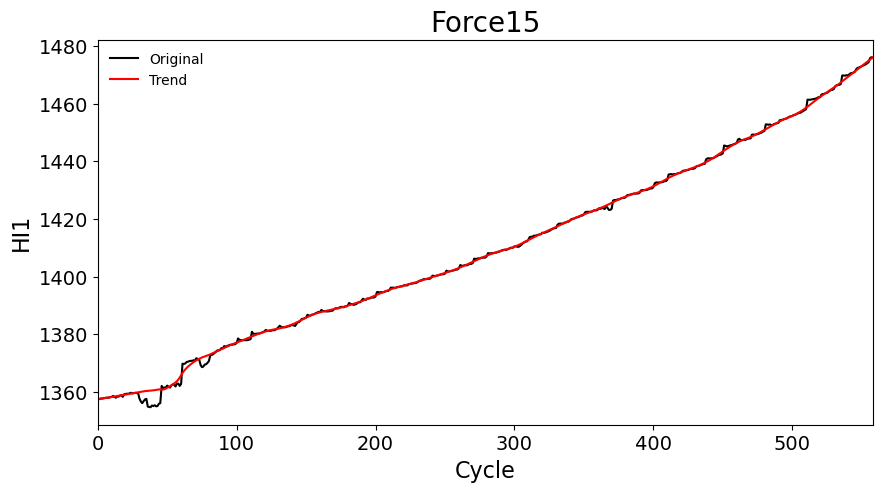

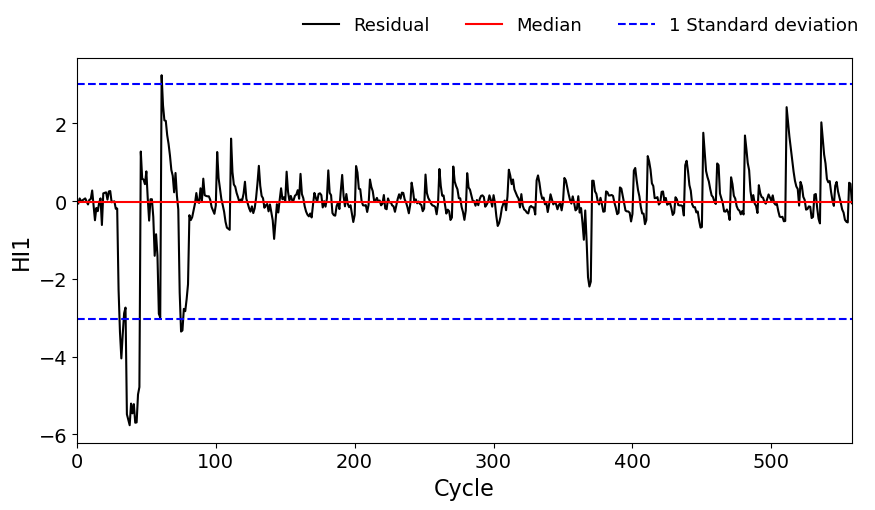

31
32
33
36
37
38
39
40
41
42
43
44
45
61
75
76


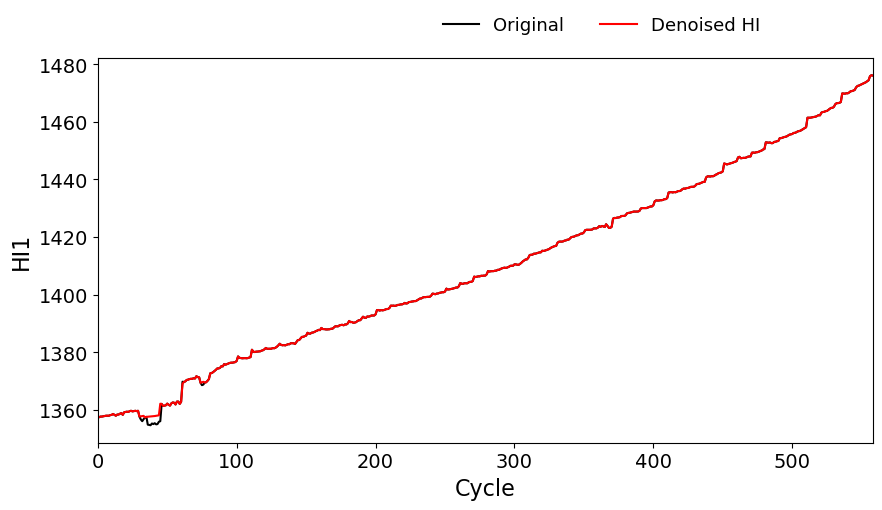

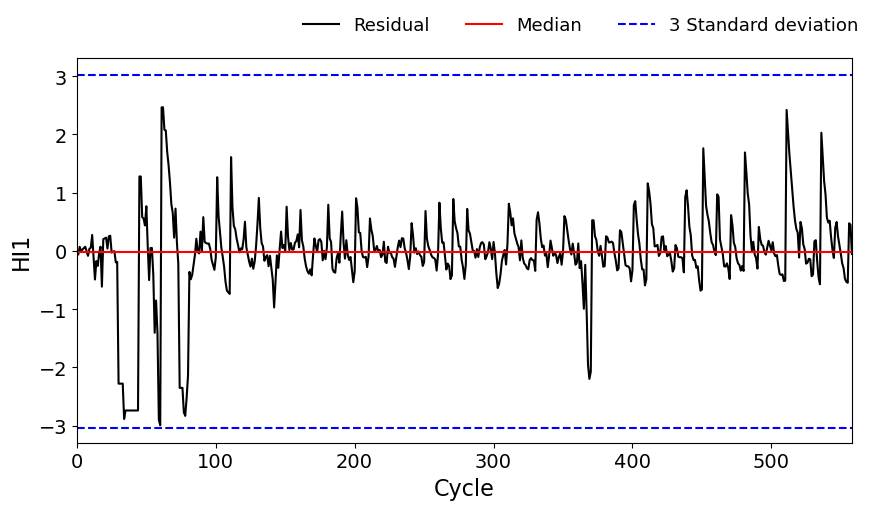

In [6]:
##############################################################
##############################################################

x= data['Cycle']
y= data['max.']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['max.']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+3*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-3*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    #t=y_res[cycle-1]
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'max.'].iloc[0]
    else :
        print(cycle)
        if cycle==1:
            denoised_val=data.loc[data['Cycle']==cycle+1,'max.'].iloc[0]
        elif cycle==len(y_res):
            denoised_val=data.loc[data['Cycle']==cycle-1,'max.'].iloc[0]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_max=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_max,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

#########

plt.figure(figsize=(10,5))
plt.plot(x, y_denoised_max-y_trend,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+3*std,color='blue',linestyle='--',label='3 Standard deviation')
plt.axhline(median-3*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


y_res_2=y_denoised_max-y_trend
for t in y_res_2:
    if t>(3*std) or t<-(3*std):
        print("outlier")
    else:
        pass




(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            WLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.394e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        07:08:22   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1054.9563     39.748     26.541      0.0

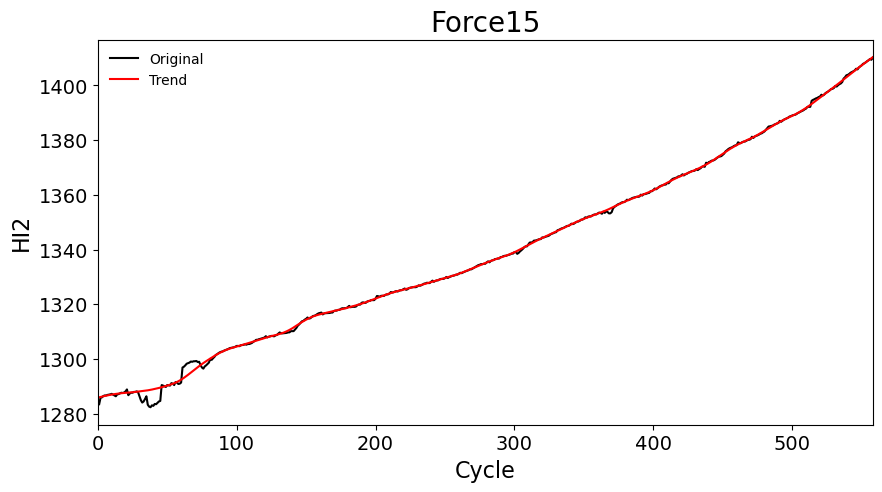

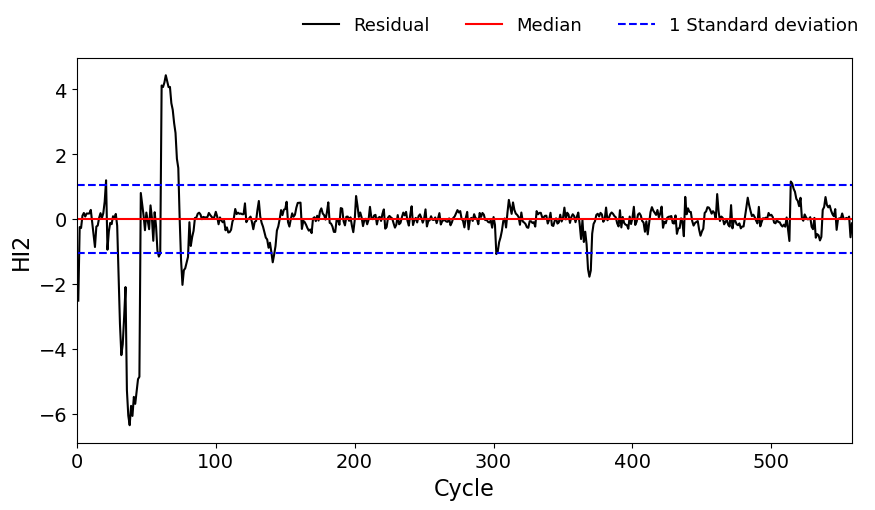

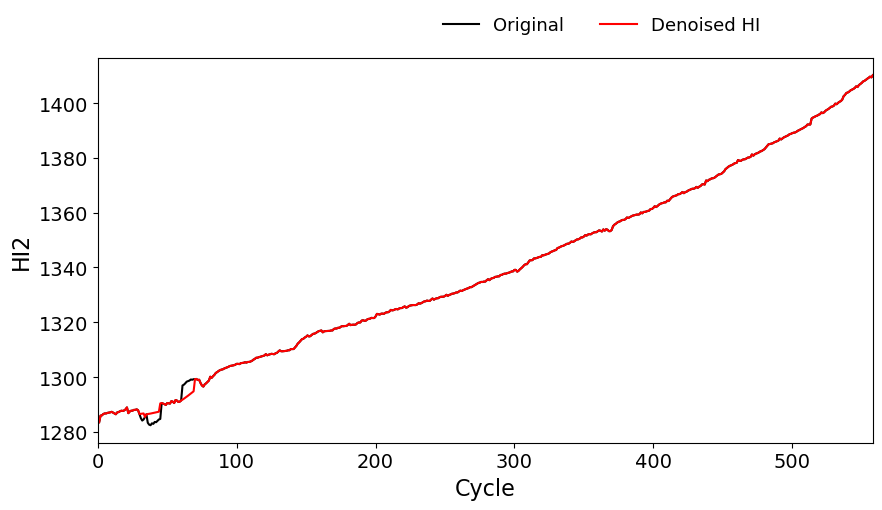

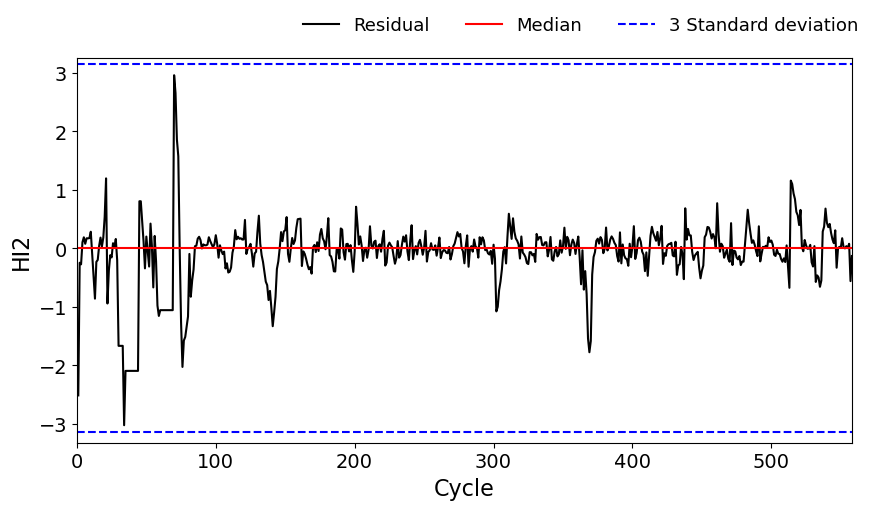

In [7]:
x= data['Cycle']
y= data['min.']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['min.']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'min.'].iloc[0]
    else :
        if cycle==1:
            denoised_val=data.loc[data['Cycle']==cycle+1,'min.'].iloc[0]
        elif cycle==len(y_res):
            denoised_val=data.loc[data['Cycle']==cycle-1,'min.'].iloc[0]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_min=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_min,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

#########

plt.figure(figsize=(10,5))
plt.plot(x, y_denoised_min-y_trend,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+3*std,color='blue',linestyle='--',label='3 Standard deviation')
plt.axhline(median-3*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


y_res_2=y_denoised_min-y_trend
for t in y_res_2:
    if t>(3*std) or t<-(3*std):
        print("outlier")
    else:
        pass



(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.589
Model:                            WLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     397.1
Date:                Mon, 18 Mar 2024   Prob (F-statistic):          8.90e-108
Time:                        07:08:25   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4760     31.313     -0.271      0.7

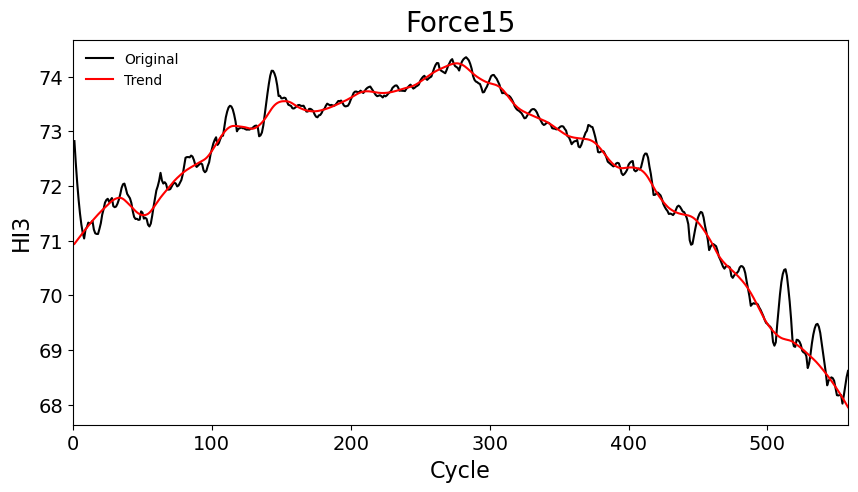

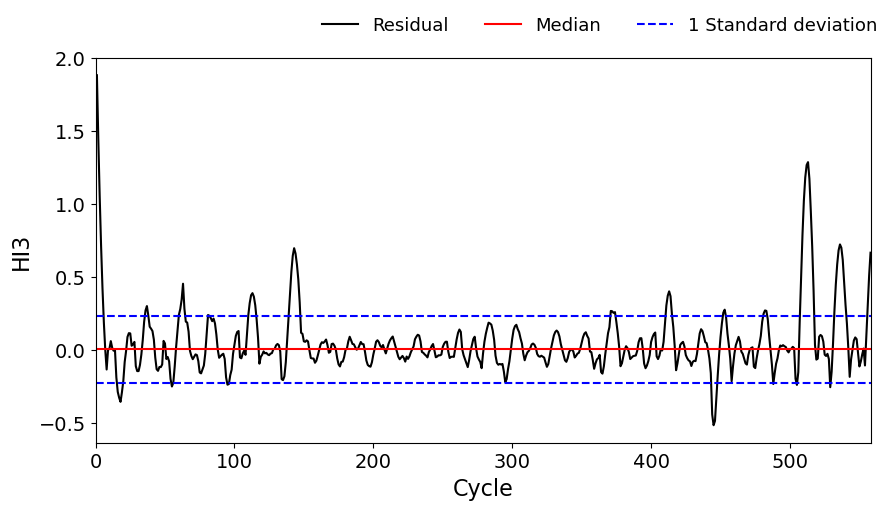

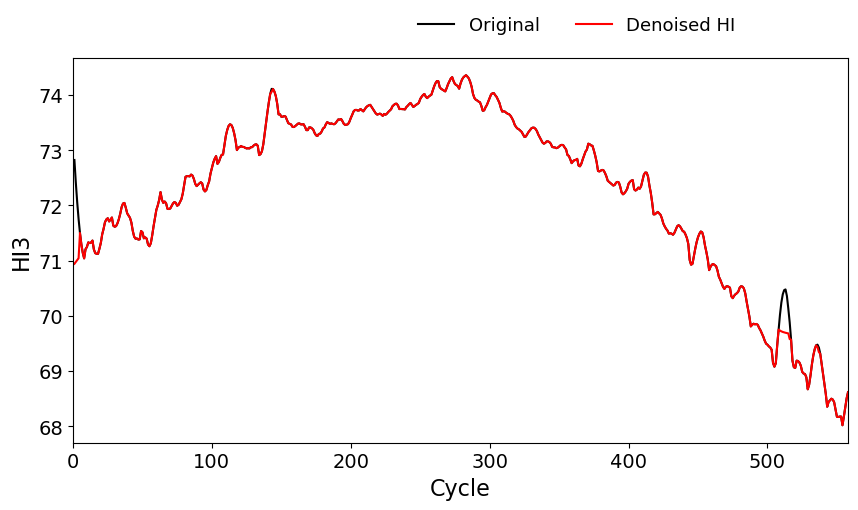

In [8]:
x= data['Cycle']
y= data['max.-min.']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['max.-min.']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI3",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI3",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'max.-min.'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_maxmin=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_maxmin,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI3",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

y_res_2=y_denoised_maxmin-y_trend
for t in y_res_2:
    if t>(3*std) or t<-(3*std):
        print("outlier")
    else:
        pass


(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            WLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     81.02
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.35e-31
Time:                        07:08:28   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7813      2.464      4.781      0.0

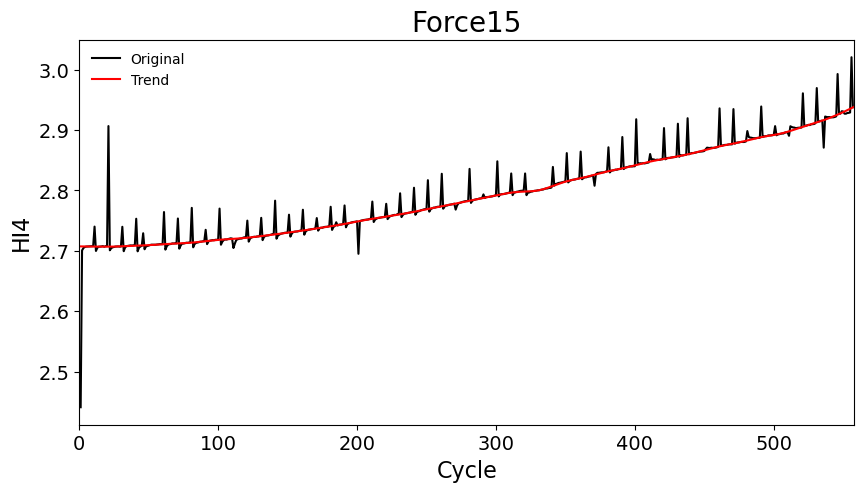

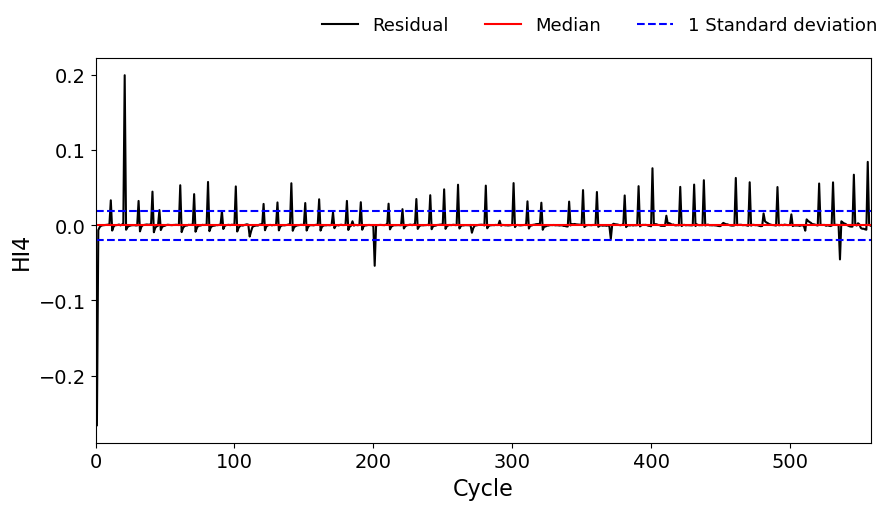

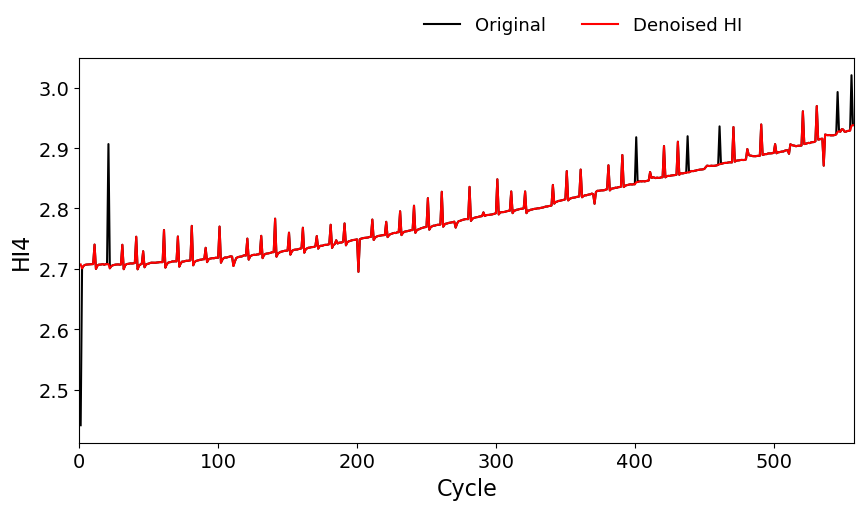

In [9]:
x= data['Cycle']
y= data['CIV']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['CIV']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI4",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI4",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CIV'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_civ=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_civ,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI4",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            WLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     129.9
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           5.32e-47
Time:                        07:08:31   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1135      4.076      2.727      0.0

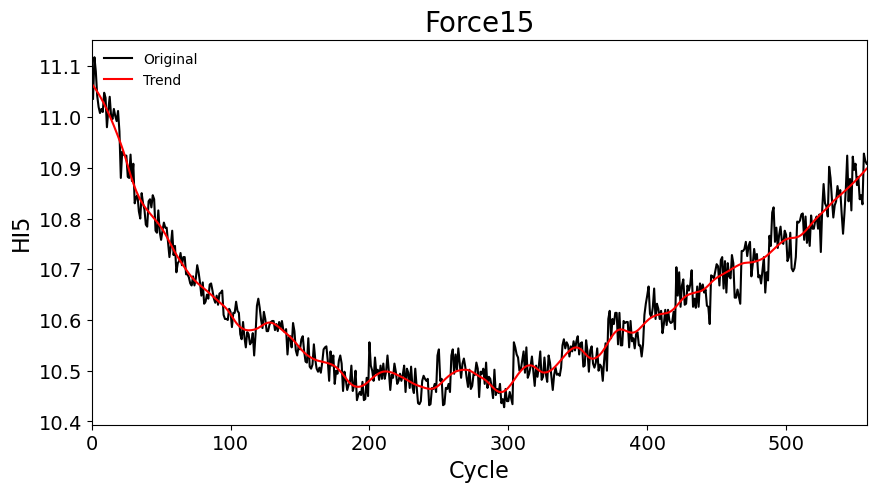

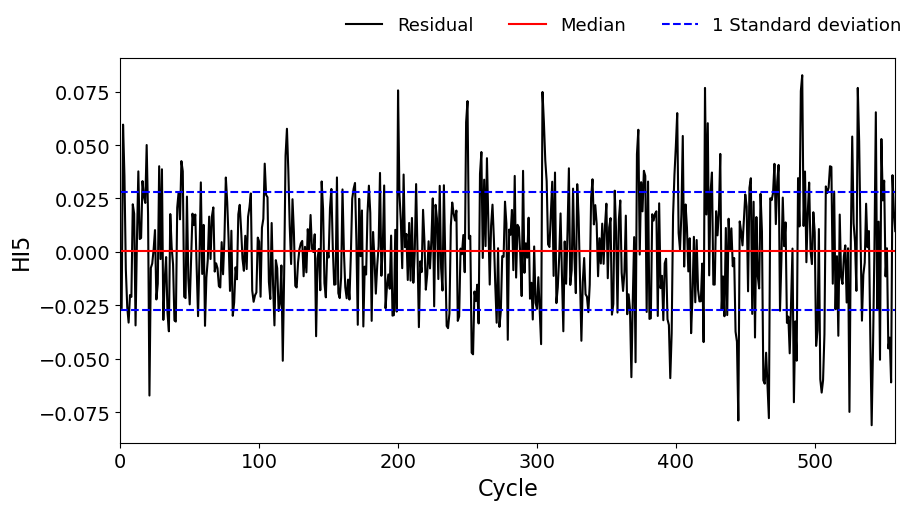

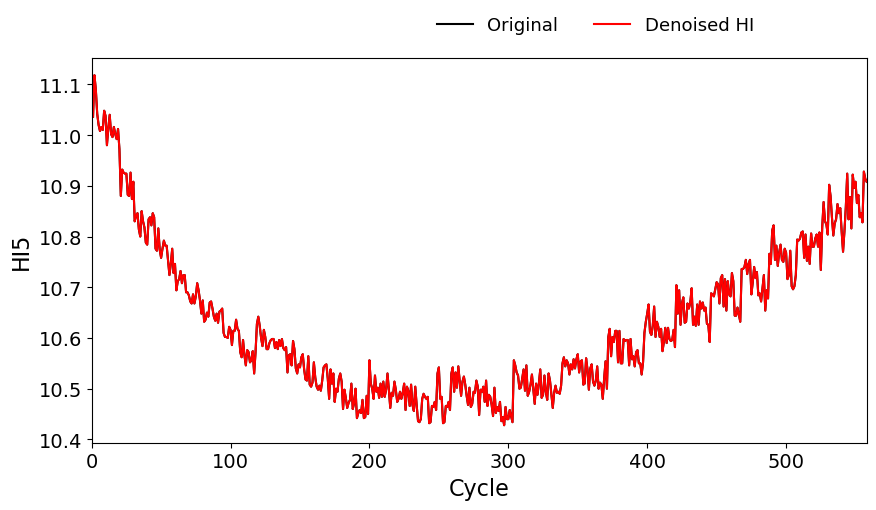

In [10]:
x= data['Cycle']
y= data['CCVIS']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['CCVIS']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI5",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI5",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CCVIS'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CCVIS=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CCVIS,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI5",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(558,)
(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.977
Date:                Mon, 18 Mar 2024   Prob (F-statistic):             0.0193
Time:                        07:08:34   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0599      3.835      1.319      0.1

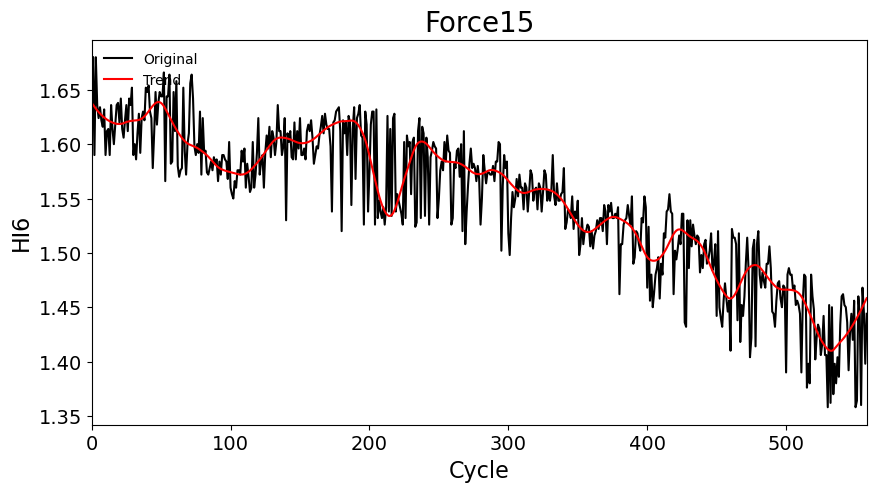

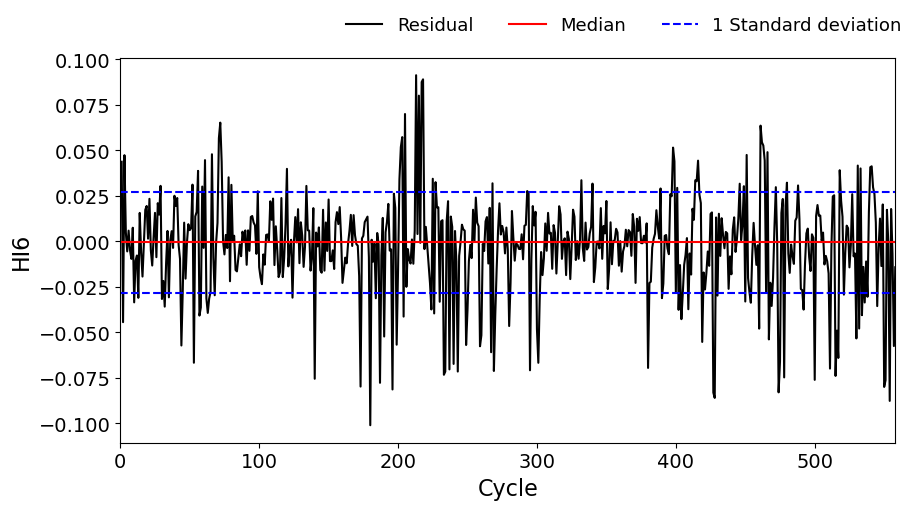

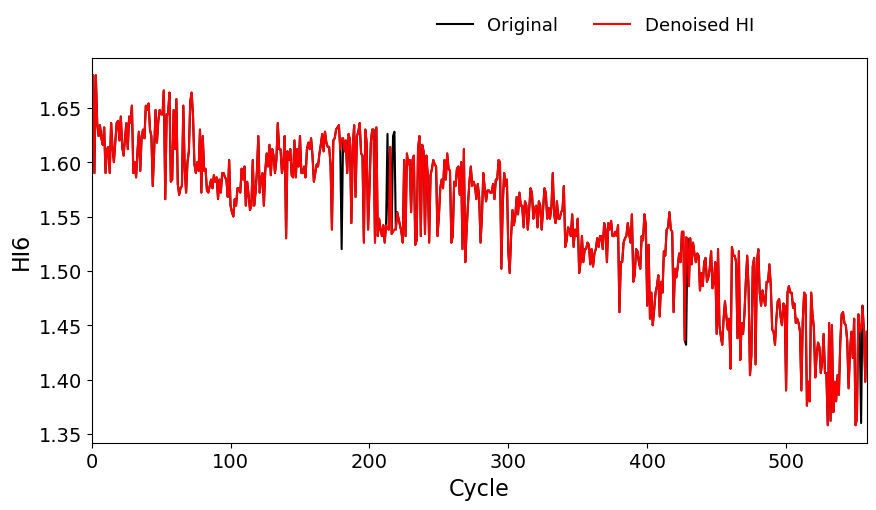

In [11]:
x= data['Cycle']
y= data['CCVES']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)
print(y.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['CCVES']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI6",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI6",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CCVES'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CCVES=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CCVES,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI6",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(558,)
(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.191
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           0.000312
Time:                        07:08:37   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1481      0.063     -2.355      0.0

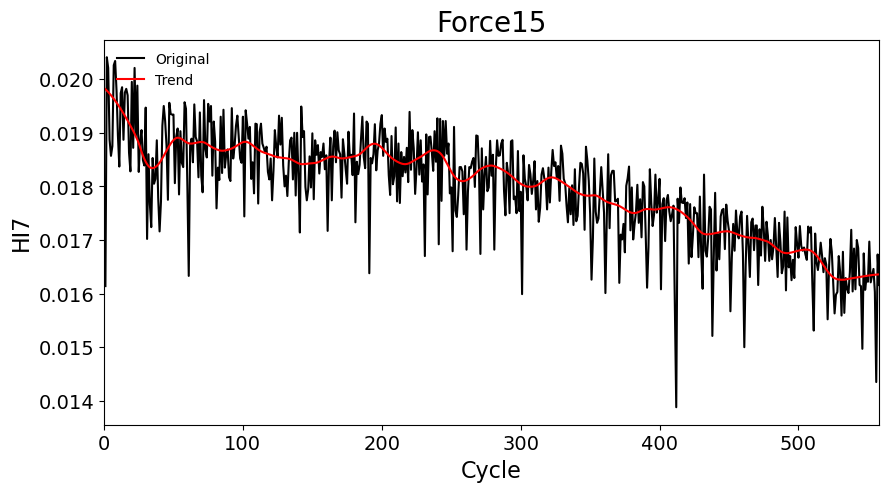

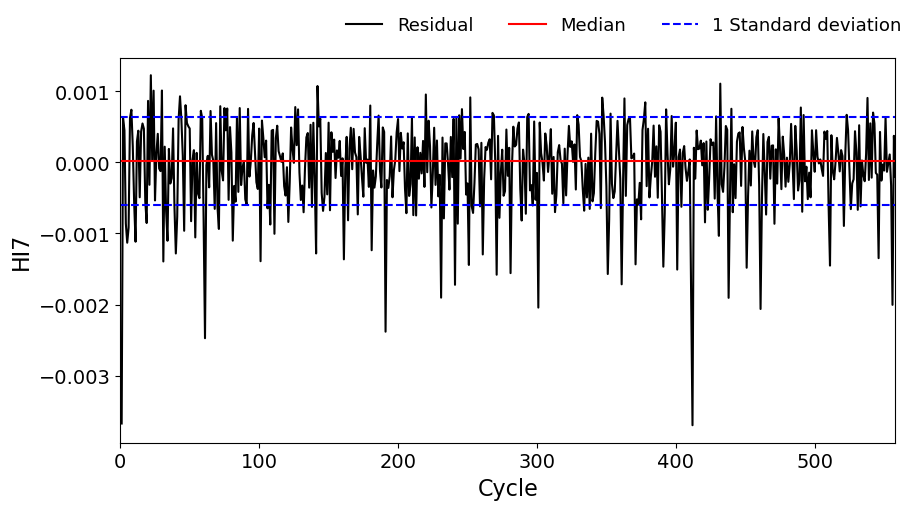

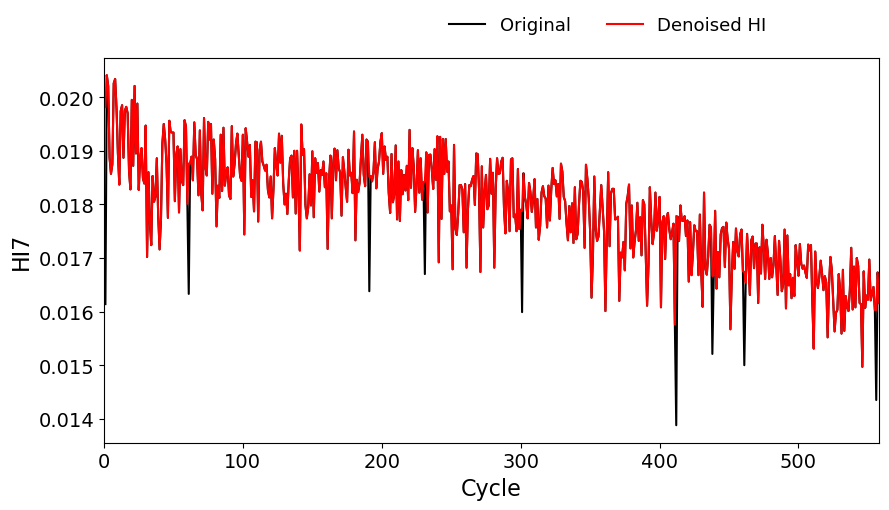

In [12]:
x= data['Cycle']
y= data.iloc[0:,8]

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)
print(y.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data.iloc[0:,8]
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI7",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI7",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CVIS (dt)'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CVIS=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CVIS,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI7",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(558,)
(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     17.74
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           3.40e-08
Time:                        07:08:40   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.004      2.315      0.0

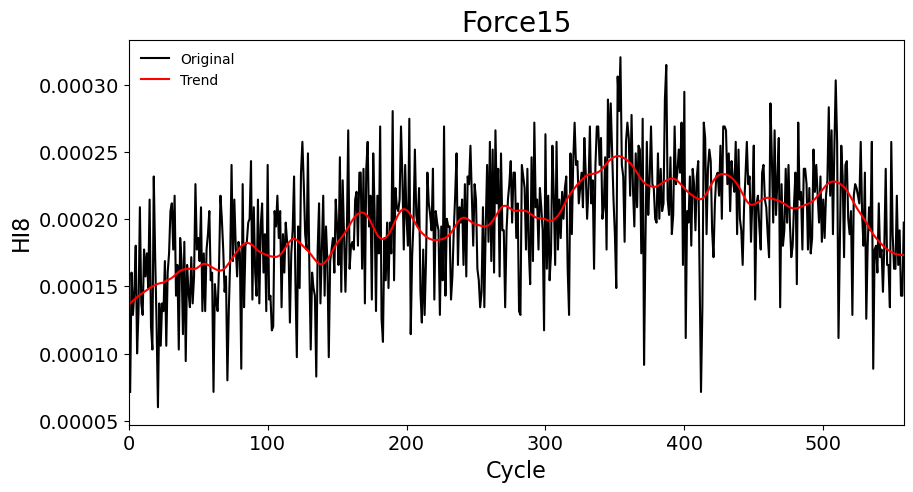

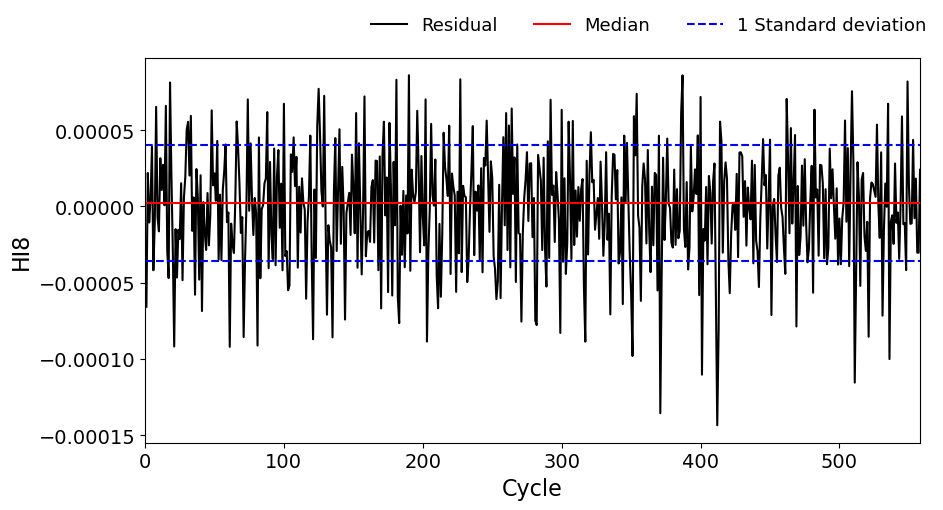

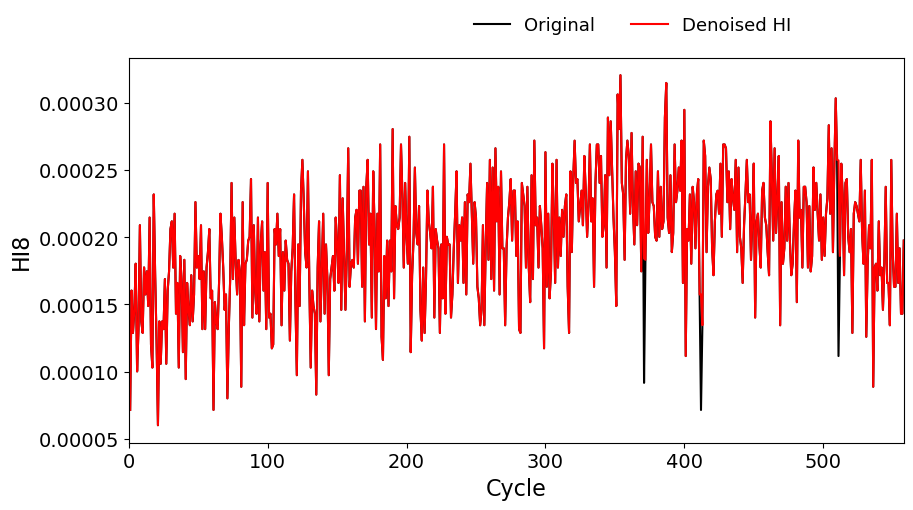

In [13]:
x= data['Cycle']
y= data.iloc[0:,9]

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)
print(y.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data.iloc[0:,9]
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI8",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI8",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CVES (dt)'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CVES=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CVES,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI8",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(558,)


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            WLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     340.9
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           2.63e-97
Time:                        07:08:43   Log-Likelihood:                   -inf
No. Observations:                 558   AIC:                               inf
Df Residuals:                     555   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0303      0.251      8.074      0.0

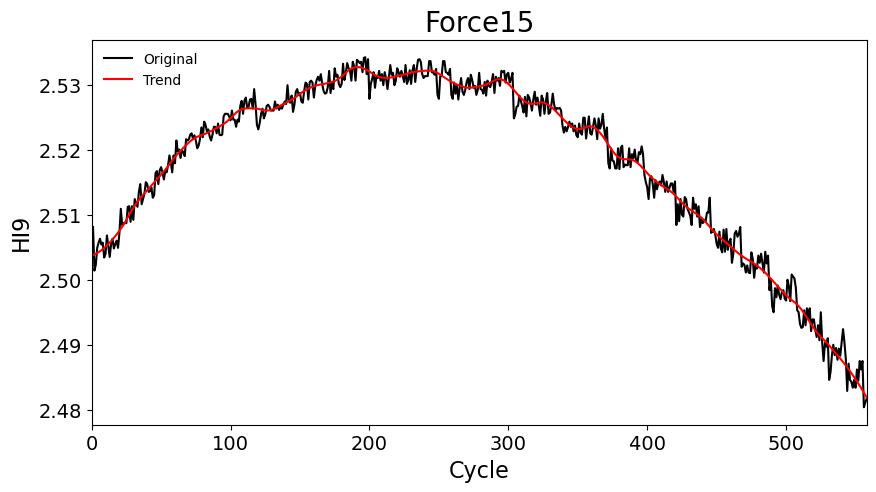

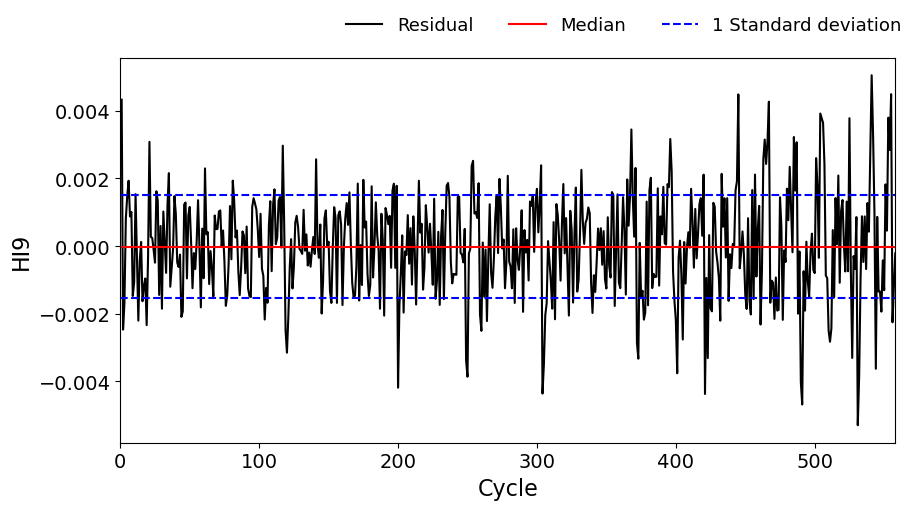

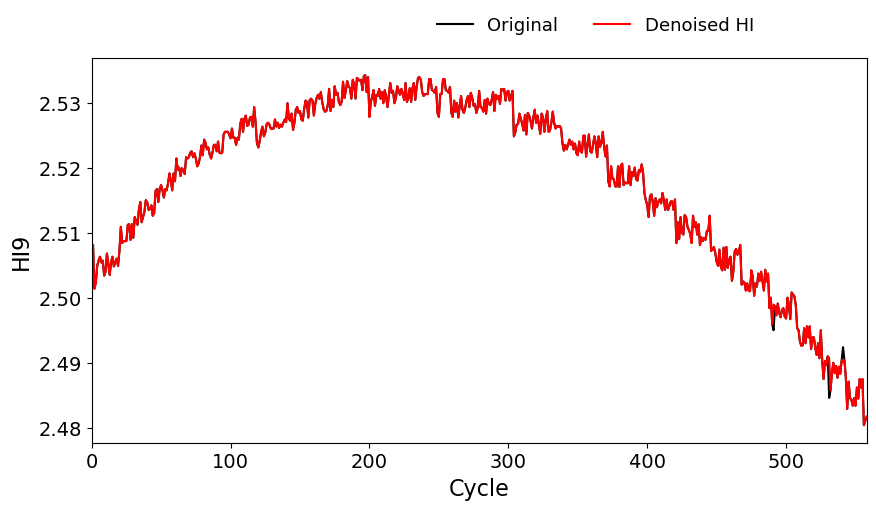

In [14]:
x= data['Cycle']
y= data['DIV']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['DIV']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI9",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI9",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-3)*std<=t<=median+3*std:
        denoised_val=data.loc[data['Cycle']==cycle,'DIV'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=denoised_1 if abs(denoised_1) < abs(denoised_2) else denoised_2
            
            denoised_val=y_trend[cycle-1]+target # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_DIV=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_DIV,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI9",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


In [15]:
df = pd.DataFrame({'HI1': y_denoised_max, 'HI2': y_denoised_min, 'HI3': y_denoised_maxmin,
                  'HI4': y_denoised_civ, 'HI5': y_denoised_CCVIS, 'HI6': y_denoised_CCVES,
                  'HI7': y_denoised_CVIS, 'HI8': y_denoised_CVES, 'HI9': y_denoised_DIV})

print(df)

            HI1         HI2        HI3       HI4     HI5       HI6       HI7  \
0    1357.50000  1283.50000  70.940750  2.707436  11.036  1.680000  0.019814   
1    1357.70000  1285.90000  70.974476  2.700800  11.118  1.590000  0.020410   
2    1357.70000  1286.00000  71.008122  2.704800  11.090  1.680000  0.020210   
3    1357.80000  1286.50000  71.041666  2.706500  11.042  1.636000  0.018870   
4    1357.90000  1286.70000  71.498560  2.707100  11.020  1.624000  0.018570   
..          ...         ...        ...       ...     ...       ...       ...   
553  1474.01238  1408.88011  68.016940  2.928400  10.846  1.446516  0.016460   
554  1474.37071  1409.21711  68.172180  2.929000  10.828  1.468000  0.016030   
555  1475.76866  1409.65740  68.342430  2.936639  10.928  1.446000  0.016033   
556  1476.11786  1409.38332  68.504510  2.937800  10.914  1.398000  0.016730   
557  1475.99312  1410.17343  68.615640  2.938000  10.908  1.444000  0.016160   

          HI8     HI9  
0    0.000072  

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
# 예제 데이터프레임 생성 (558, 9) 형태라고 가정
# data = pd.DataFrame(...)

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()

# 데이터 정규화 수행
data_normalized = scaler.fit_transform(df)

# 정규화된 데이터를 다시 DataFrame으로 변환
data_norm_denoised = pd.DataFrame(data_normalized, columns=df.columns)

# 정규화된 데이터 확인
data_norm_denoised.head()

,HI1,HI2,HI3,HI4,HI5,HI6,HI7,HI8,HI9
0,0.000842,0.000000,0.461193,0.044625,0.881159,1.000000,0.890431,0.043789,0.514870
1,0.002527,0.018946,0.466513,0.020423,1.000000,0.720497,1.000000,0.384692,0.390335
2,0.002527,0.019736,0.471820,0.035011,0.959420,1.000000,0.963235,0.263696,0.407063
3,0.003369,0.023683,0.477111,0.041211,0.889855,0.863354,0.716912,0.329476,0.455390
4,0.004212,0.025262,0.549180,0.043399,0.857971,0.826087,0.661765,0.461515,0.470260


In [18]:
data=pd.read_csv("./data_paper/Force15kgf.csv")

print(data.shape)

# data가 pandas DataFrame이고, shape이 (558, 13)이라고 가정합니다.

# 'cycle', 'soh', 'DVSOC50' 열을 제외하고 나머지 데이터만 유지
# 여기서 'cycle'이 2개 있다고 하셨으니, 구체적인 열 이름이 필요할 수 있습니다.
# 예를 들어, 'cycle1', 'cycle2' 같이 구분이 되어 있다면 아래와 같이 작성합니다.
data_reduced = data.drop(['Unnamed: 0', 'Cycle', 'SOH', 'DVSOC50'], axis=1)

# 결과 확인
print(data_reduced.shape)  # 이제 (558, 9)가 되어야 합니다.
data_reduced.head()

(558, 13)
(558, 9)


,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS (dt),CVES (dt),DIV
0,1357.5,1283.5,72.82119,2.4414,11.036,1.680,0.01614,0.000072,2.5081
1,1357.7,1285.9,72.41452,2.7008,11.118,1.590,0.02041,0.000160,2.5014
2,1357.7,1286.0,72.05853,2.7048,11.090,1.680,0.02021,0.000129,2.5023
3,1357.8,1286.5,71.75321,2.7065,11.042,1.636,0.01887,0.000146,2.5049
4,1357.9,1286.7,71.49856,2.7071,11.020,1.624,0.01857,0.000180,2.5057


In [19]:
# 예제 데이터프레임 생성 (558, 9) 형태라고 가정
# data = pd.DataFrame(...)

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()

# 데이터 정규화 수행
data_normalized = scaler.fit_transform(data_reduced)

# 정규화된 데이터를 다시 DataFrame으로 변환
data_normalized = pd.DataFrame(data_normalized, columns=data_reduced.columns)

# 정규화된 데이터 확인
data_normalized.head()

,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS (dt),CVES (dt),DIV
0,0.023061,0.008609,0.757808,0.000000,0.881159,1.000000,0.346095,0.043789,0.514870
1,0.024708,0.027392,0.693661,0.448014,1.000000,0.720497,1.000000,0.384692,0.390335
2,0.024708,0.028175,0.637508,0.454922,0.959420,1.000000,0.969372,0.263696,0.407063
3,0.025532,0.032088,0.589348,0.457858,0.889855,0.863354,0.764165,0.329476,0.455390
4,0.026355,0.033653,0.549180,0.458895,0.857971,0.826087,0.718224,0.461515,0.470260


In [20]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import random


def build_autoencoder(input_dim, encoding_dim):
    # 입력 레이어
    input_layer = Input(shape=(input_dim,))
    
    # 인코더 레이어: 입력을 encoding_dim 차원으로 압축, He 초기화 사용
    encoded = Dense(encoding_dim[0], activation='elu')(input_layer)
    encoded = Dense(encoding_dim[1], activation='elu')(encoded)
    
    # 디코더 레이어: encoding_dim 차원을 다시 입력 차원으로 복원, He 초기화 사용
    decoded = Dense(encoding_dim[0], activation='elu')(encoded)
    decoded = Dense(input_dim, activation='elu')(decoded)
    
    # 오토인코더 모델 생성
    autoencoder = Model(input_layer, decoded)
    
    # 인코더 모델 생성
    encoder = Model(input_layer, encoded)
    
    # 디코더 모델 생성
    encoded_input = Input(shape=(encoding_dim[1],))
    decoder_layer1 = autoencoder.layers[-2](encoded_input)
    decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
    decoder = Model(encoded_input, decoder_layer2)
    
    return autoencoder, encoder, decoder

# 모델 구축
input_dim = 9  # 입력 차원
encoding_dim = [6, 4]  # 인코더의 두 레이어에서의 차원
autoencoder, encoder, decoder = build_autoencoder(input_dim, encoding_dim)

from tensorflow.keras.optimizers import Adam

# 모델 컴파일
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 63        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [21]:
# data.shape는 (558, 9)입니다.

# 첫 277개 행을 훈련 데이터로 사용
X_train = data_norm_denoised
X_test=data_norm_denoised

# 모델 훈련
autoencoder.fit(X_train, X_train, epochs=500, batch_size=16,validation_data=(X_train,X_train))

# 테스트 데이터에 대한 재구성
reconstructed = autoencoder.predict(X_test)




Train on 558 samples, validate on 558 samples
Epoch 1/500
558/558 [==============================] - 1s 986us/sample - loss: 0.3301 - val_loss: 0.2448
Epoch 2/500
558/558 [==============================] - 0s 120us/sample - loss: 0.1899 - val_loss: 0.1416
Epoch 3/500
558/558 [==============================] - 0s 120us/sample - loss: 0.1111 - val_loss: 0.0846
Epoch 4/500
558/558 [==============================] - 0s 120us/sample - loss: 0.0690 - val_loss: 0.0561
Epoch 5/500
558/558 [==============================] - 0s 118us/sample - loss: 0.0487 - val_loss: 0.0424
Epoch 6/500
558/558 [==============================] - 0s 120us/sample - loss: 0.0385 - val_loss: 0.0348
Epoch 7/500
558/558 [==============================] - 0s 120us/sample - loss: 0.0324 - val_loss: 0.0299
Epoch 8/500
558/558 [==============================] - 0s 120us/sample - loss: 0.0283 - val_loss: 0.0265
Epoch 9/500
558/558 [==============================] - 0s 117us/sample - loss: 0.0253 - val_loss: 0.0241
Epoch 10/

Epoch 78/500
558/558 [==============================] - 0s 134us/sample - loss: 0.0054 - val_loss: 0.0053
Epoch 79/500
558/558 [==============================] - 0s 136us/sample - loss: 0.0053 - val_loss: 0.0053
Epoch 80/500
558/558 [==============================] - 0s 136us/sample - loss: 0.0053 - val_loss: 0.0053
Epoch 81/500
558/558 [==============================] - 0s 138us/sample - loss: 0.0053 - val_loss: 0.0052
Epoch 82/500
558/558 [==============================] - 0s 138us/sample - loss: 0.0053 - val_loss: 0.0052
Epoch 83/500
558/558 [==============================] - 0s 138us/sample - loss: 0.0052 - val_loss: 0.0052
Epoch 84/500
558/558 [==============================] - 0s 136us/sample - loss: 0.0052 - val_loss: 0.0052
Epoch 85/500
558/558 [==============================] - 0s 138us/sample - loss: 0.0052 - val_loss: 0.0052
Epoch 86/500
558/558 [==============================] - 0s 138us/sample - loss: 0.0052 - val_loss: 0.0051
Epoch 87/500
558/558 [========================

Epoch 155/500
558/558 [==============================] - 0s 149us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 156/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 157/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 158/500
558/558 [==============================] - 0s 161us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 159/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 160/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0040 - val_loss: 0.0039
Epoch 161/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 162/500
558/558 [==============================] - 0s 152us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 163/500
558/558 [==============================] - 0s 154us/sample - loss: 0.0039 - val_loss: 0.0038
Epoch 164/500
558/558 [==============

558/558 [==============================] - 0s 163us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 232/500
558/558 [==============================] - 0s 152us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 233/500
558/558 [==============================] - 0s 156us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 234/500
558/558 [==============================] - 0s 183us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 235/500
558/558 [==============================] - 0s 167us/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 236/500
558/558 [==============================] - 0s 154us/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 237/500
558/558 [==============================] - 0s 167us/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 238/500
558/558 [==============================] - 0s 155us/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 239/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 240/500
558/558 [============================

558/558 [==============================] - 0s 152us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 308/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 309/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 310/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 311/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 312/500
558/558 [==============================] - 0s 149us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 313/500
558/558 [==============================] - 0s 154us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 314/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 315/500
558/558 [==============================] - 0s 152us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 316/500
558/558 [============================

558/558 [==============================] - 0s 149us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 384/500
558/558 [==============================] - 0s 158us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 385/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 386/500
558/558 [==============================] - 0s 154us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 387/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 388/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 389/500
558/558 [==============================] - 0s 149us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 390/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 391/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 392/500
558/558 [============================

558/558 [==============================] - 0s 152us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 460/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 461/500
558/558 [==============================] - 0s 161us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 462/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 463/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 464/500
558/558 [==============================] - 0s 151us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 465/500
558/558 [==============================] - 0s 158us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 466/500
558/558 [==============================] - 0s 147us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 467/500
558/558 [==============================] - 0s 160us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 468/500
558/558 [============================

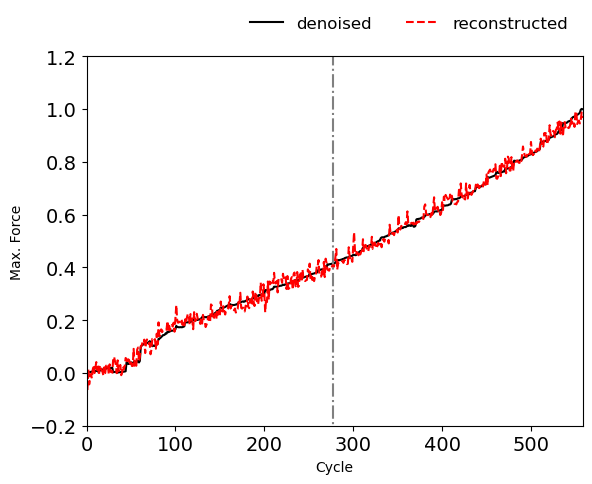

In [22]:

y= reconstructed[:,0]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI1']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("Max. Force")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

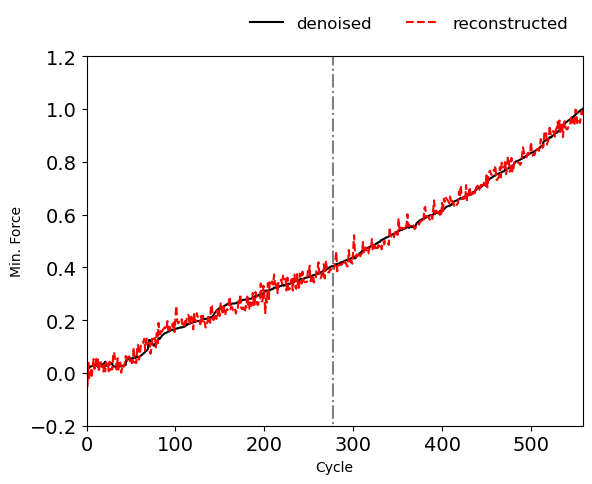

In [23]:
y= reconstructed[:,1]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI2']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("Min. Force")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

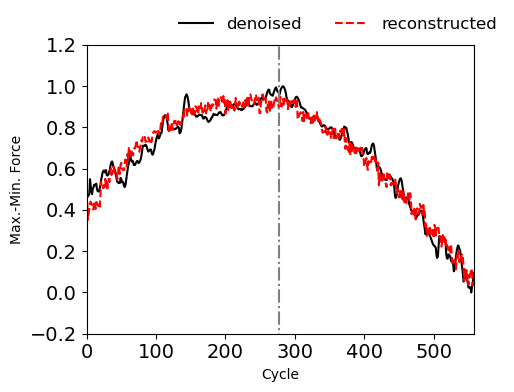

In [24]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,2]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI3']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("Max.-Min. Force")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

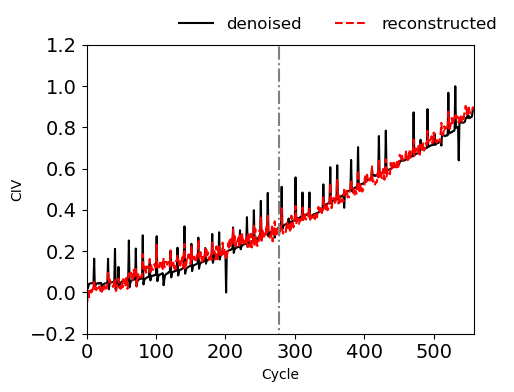

In [25]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,3]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI4']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("CIV")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

<Figure size 500x375 with 0 Axes>

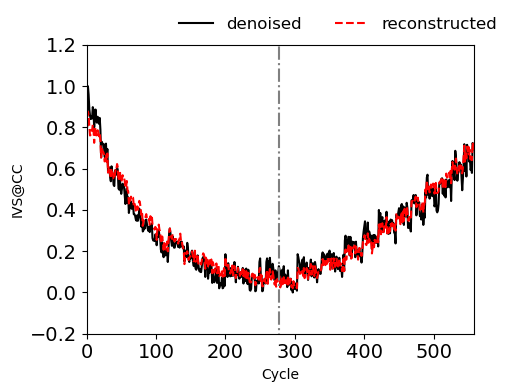

In [26]:
plt.figure(figsize=(5,3.75))
plt.figure(figsize=(5,3.75))
y= reconstructed[:,4]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI5']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("IVS@CC")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

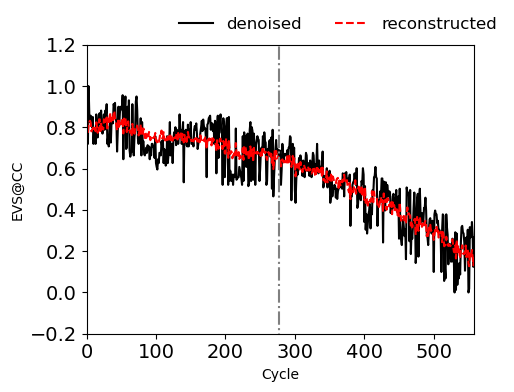

In [27]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,5]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI6']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("EVS@CC")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

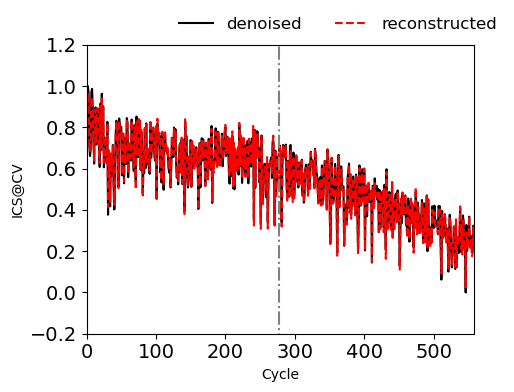

In [28]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,6]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI7']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("ICS@CV")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

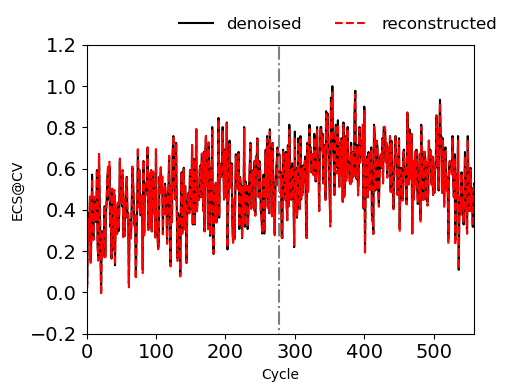

In [29]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,7]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI8']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("ECS@CV")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

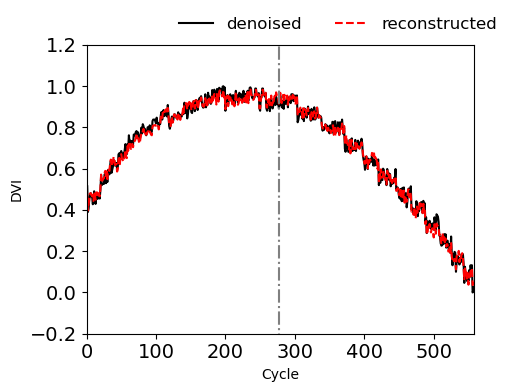

In [30]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,8]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI9']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("DVI")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

x=reconstructed
y=data['SOH']



x_train=x[:295,:]
y_train=y[:295]

x_test=x[295:,:]
y_test=y[295:]




kernel = C(1) * RBF(length_scale=3.0) + WhiteKernel(noise_level=0.04,)

# GPR 모델 생성 및 학습
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(x_train, y_train)

# SOH 추정
y_pred, sigma = gp.predict(x_test, return_std=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

# 실제 SOH 값(y)과 예측된 SOH 값(y_pred)을 사용하여 RMSE 계산
rmse = sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)

RMSE: 0.08181009652465815


In [32]:
x=reconstructed[:,:3]
y=data['SOH']



x_train=x[:295,:]
y_train=y[:295]

x_test=x[295:,:]
y_test=y[295:]

kernel = C(3) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.2)

# GPR 모델 생성 및 학습
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=False)
gp.fit(x_train, y_train)

# SOH 추정
y_mechanical, sigma = gp.predict(x_test, return_std=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

# 실제 SOH 값(y)과 예측된 SOH 값(y_pred)을 사용하여 RMSE 계산
rmse = sqrt(mean_squared_error(y_test, y_mechanical))

print("RMSE:", rmse)

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RMSE: 0.010843369194497453


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [33]:
x=reconstructed[:,3:]
y=data['SOH']



x_train=x[:295,:]
y_train=y[:295]

x_test=x[295:,:]
y_test=y[295:]

kernel = C(0.3) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.2,)

# GPR 모델 생성 및 학습
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gp.fit(x_train, y_train)

# SOH 추정
y_Impedance, sigma = gp.predict(x_test, return_std=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

# 실제 SOH 값(y)과 예측된 SOH 값(y_pred)을 사용하여 RMSE 계산
rmse = sqrt(mean_squared_error(y_test, y_Impedance))

print("RMSE:", rmse)

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RMSE: 0.03984704393273383


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


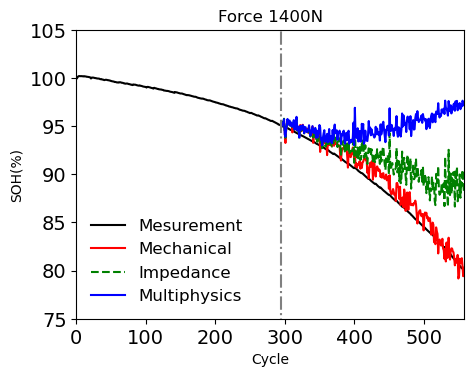

In [40]:
plt.figure(figsize=(5,3.75))
y_2= y_mechanical*100
y_4=y_pred*100
y_3=y_Impedance*100
x= np.arange(1, len(y) + 1)
x_1=np.arange(296, len(y)+1)
y_soh=data['SOH']*100
plt.plot(x,y_soh,'k-',label='Mesurement')
plt.plot(x_1,y_2,'r-',label='Mechanical')
plt.plot(x_1,y_3,'g--',label='Impedance')
plt.plot(x_1,y_4,'b-',label='Multiphysics')

plt.title("Force 1400N")
plt.xlabel("Cycle")
plt.ylabel("SOH(%)")
plt.xlim([0,len(x)])
plt.ylim(75,105)
plt.axvline(295,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='lower left',frameon=False,fontsize=12)
plt.show()



In [34]:
x_1=np.arange(296, len(y_2) + 1)
print(x.shape)
print(y_2.shape)
print(len(y_2))
print(x_1)

(558,)
(263,)
263
[]


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
x=reconstructed
y=data['SOH']



x_train=x[:295,:]
y_train=y[:295]



# MLP 모델 구성
mlp_model = Sequential([
    Flatten(input_shape=(9,)),  # 9개의 특성을 가진 데이터를 평탄화
    Dense(16, activation='relu'),  # 첫 번째 은닉 레이어
    Dense(64, activation='relu'),  # 두 번째 은닉 레이어
    Dense(32, activation='relu'),  # 세 번째 은닉 레이어
    Dense(1)  # 출력 레이어
])

# 모델 컴파일
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error')

# 모델 요약
mlp_model.summary()

history = mlp_model.fit(x_train, y_train, epochs=500, batch_size=16, validation_split=0.2)
y_mlp= mlp_model.predict(x)

# 성능 평가 (RMSE 계산)
rmse = sqrt(mean_squared_error(y, y_mlp))
print("Test RMSE: ", rmse)

ERROR! Session/line number was not unique in database. History logging moved to new session 359
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________
Train on 236 samples, va

236/236 [==============================] - 0s 119us/sample - loss: 1.1926e-04 - val_loss: 1.9376e-04
Epoch 64/500
236/236 [==============================] - 0s 123us/sample - loss: 1.1733e-04 - val_loss: 1.9350e-04
Epoch 65/500
236/236 [==============================] - 0s 119us/sample - loss: 1.1248e-04 - val_loss: 2.0395e-04
Epoch 66/500
236/236 [==============================] - 0s 119us/sample - loss: 1.1311e-04 - val_loss: 1.6196e-04
Epoch 67/500
236/236 [==============================] - 0s 114us/sample - loss: 1.1227e-04 - val_loss: 1.8639e-04
Epoch 68/500
236/236 [==============================] - 0s 127us/sample - loss: 1.0357e-04 - val_loss: 1.7839e-04
Epoch 69/500
236/236 [==============================] - 0s 119us/sample - loss: 1.0004e-04 - val_loss: 1.7177e-04
Epoch 70/500
236/236 [==============================] - 0s 119us/sample - loss: 9.9103e-05 - val_loss: 1.4732e-04
Epoch 71/500
236/236 [==============================] - 0s 123us/sample - loss: 9.2275e-05 - val_loss

236/236 [==============================] - 0s 127us/sample - loss: 1.2585e-05 - val_loss: 3.6987e-05
Epoch 135/500
236/236 [==============================] - 0s 123us/sample - loss: 1.1327e-05 - val_loss: 5.5906e-05
Epoch 136/500
236/236 [==============================] - 0s 123us/sample - loss: 1.0884e-05 - val_loss: 7.6136e-05
Epoch 137/500
236/236 [==============================] - 0s 119us/sample - loss: 1.0968e-05 - val_loss: 8.2146e-05
Epoch 138/500
236/236 [==============================] - 0s 136us/sample - loss: 1.2686e-05 - val_loss: 3.9532e-05
Epoch 139/500
236/236 [==============================] - 0s 140us/sample - loss: 1.1701e-05 - val_loss: 9.2227e-05
Epoch 140/500
236/236 [==============================] - 0s 127us/sample - loss: 1.0491e-05 - val_loss: 7.7795e-05
Epoch 141/500
236/236 [==============================] - 0s 123us/sample - loss: 9.2029e-06 - val_loss: 5.1077e-05
Epoch 142/500
236/236 [==============================] - 0s 119us/sample - loss: 9.7449e-06 - 

236/236 [==============================] - 0s 131us/sample - loss: 5.3116e-06 - val_loss: 8.9646e-05
Epoch 206/500
236/236 [==============================] - 0s 123us/sample - loss: 5.0130e-06 - val_loss: 1.1892e-04
Epoch 207/500
236/236 [==============================] - 0s 123us/sample - loss: 5.4384e-06 - val_loss: 1.1945e-04
Epoch 208/500
236/236 [==============================] - 0s 119us/sample - loss: 4.9945e-06 - val_loss: 1.1386e-04
Epoch 209/500
236/236 [==============================] - 0s 123us/sample - loss: 6.6513e-06 - val_loss: 1.1802e-04
Epoch 210/500
236/236 [==============================] - 0s 133us/sample - loss: 6.2603e-06 - val_loss: 9.3013e-05
Epoch 211/500
236/236 [==============================] - 0s 119us/sample - loss: 4.8169e-06 - val_loss: 9.9700e-05
Epoch 212/500
236/236 [==============================] - 0s 127us/sample - loss: 5.0912e-06 - val_loss: 7.4128e-05
Epoch 213/500
236/236 [==============================] - 0s 119us/sample - loss: 5.4141e-06 - 

236/236 [==============================] - 0s 119us/sample - loss: 4.4656e-06 - val_loss: 5.4830e-05
Epoch 277/500
236/236 [==============================] - 0s 131us/sample - loss: 9.3414e-06 - val_loss: 1.4915e-04
Epoch 278/500
236/236 [==============================] - 0s 123us/sample - loss: 6.6044e-06 - val_loss: 6.4926e-05
Epoch 279/500
236/236 [==============================] - 0s 119us/sample - loss: 4.9831e-06 - val_loss: 1.1153e-04
Epoch 280/500
236/236 [==============================] - 0s 127us/sample - loss: 3.9874e-06 - val_loss: 9.2678e-05
Epoch 281/500
236/236 [==============================] - 0s 123us/sample - loss: 3.9822e-06 - val_loss: 1.2771e-04
Epoch 282/500
236/236 [==============================] - 0s 119us/sample - loss: 4.5096e-06 - val_loss: 8.4858e-05
Epoch 283/500
236/236 [==============================] - 0s 119us/sample - loss: 6.5563e-06 - val_loss: 4.5376e-05
Epoch 284/500
236/236 [==============================] - 0s 119us/sample - loss: 1.0271e-05 - 

236/236 [==============================] - 0s 123us/sample - loss: 4.5246e-06 - val_loss: 1.1192e-04
Epoch 348/500
236/236 [==============================] - 0s 131us/sample - loss: 7.4589e-06 - val_loss: 1.1362e-04
Epoch 349/500
236/236 [==============================] - 0s 131us/sample - loss: 4.9385e-06 - val_loss: 8.1361e-05
Epoch 350/500
236/236 [==============================] - 0s 140us/sample - loss: 4.5377e-06 - val_loss: 8.8964e-05
Epoch 351/500
236/236 [==============================] - 0s 131us/sample - loss: 4.8721e-06 - val_loss: 7.3713e-05
Epoch 352/500
236/236 [==============================] - 0s 127us/sample - loss: 5.0384e-06 - val_loss: 5.3277e-05
Epoch 353/500
236/236 [==============================] - 0s 123us/sample - loss: 5.2834e-06 - val_loss: 7.2378e-05
Epoch 354/500
236/236 [==============================] - 0s 119us/sample - loss: 4.2520e-06 - val_loss: 6.1958e-05
Epoch 355/500
236/236 [==============================] - 0s 123us/sample - loss: 5.5904e-06 - 

236/236 [==============================] - 0s 131us/sample - loss: 4.8607e-06 - val_loss: 6.5143e-05
Epoch 419/500
236/236 [==============================] - 0s 123us/sample - loss: 4.9155e-06 - val_loss: 7.8707e-05
Epoch 420/500
236/236 [==============================] - 0s 127us/sample - loss: 6.1349e-06 - val_loss: 6.6695e-05
Epoch 421/500
236/236 [==============================] - 0s 119us/sample - loss: 4.3255e-06 - val_loss: 5.8827e-05
Epoch 422/500
236/236 [==============================] - 0s 123us/sample - loss: 5.2427e-06 - val_loss: 1.4585e-04
Epoch 423/500
236/236 [==============================] - 0s 119us/sample - loss: 6.9841e-06 - val_loss: 9.7708e-05
Epoch 424/500
236/236 [==============================] - 0s 127us/sample - loss: 6.9328e-06 - val_loss: 7.2850e-05
Epoch 425/500
236/236 [==============================] - 0s 119us/sample - loss: 4.4474e-06 - val_loss: 8.5608e-05
Epoch 426/500
236/236 [==============================] - 0s 123us/sample - loss: 1.0786e-05 - 

236/236 [==============================] - 0s 123us/sample - loss: 6.4997e-06 - val_loss: 7.0408e-05
Epoch 490/500
236/236 [==============================] - 0s 114us/sample - loss: 4.3795e-06 - val_loss: 1.0541e-04
Epoch 491/500
236/236 [==============================] - 0s 123us/sample - loss: 1.0064e-05 - val_loss: 1.4713e-04
Epoch 492/500
236/236 [==============================] - 0s 127us/sample - loss: 1.2984e-05 - val_loss: 1.5662e-04
Epoch 493/500
236/236 [==============================] - 0s 119us/sample - loss: 7.9260e-06 - val_loss: 7.7734e-05
Epoch 494/500
236/236 [==============================] - 0s 123us/sample - loss: 5.7817e-06 - val_loss: 4.6291e-05
Epoch 495/500
236/236 [==============================] - 0s 119us/sample - loss: 8.7505e-06 - val_loss: 6.4700e-05
Epoch 496/500
236/236 [==============================] - 0s 136us/sample - loss: 1.0521e-05 - val_loss: 8.7438e-05
Epoch 497/500
236/236 [==============================] - 0s 131us/sample - loss: 5.9916e-06 - 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

x=reconstructed
y=data['SOH']

x_train=x[:295,:]
y_train=y[:295]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x=x.reshape((x.shape[0],x.shape[1],1))


# DCNN 모델 구성
dcnn_model = Sequential([
    Conv1D(filters=8, kernel_size=20, activation='relu', input_shape=(9, 1),padding='same'),  # 첫 번째 컨볼루션 레이어
    MaxPooling1D(pool_size=2),  # 첫 번째 맥스 풀링 레이어
    Conv1D(filters=8, kernel_size=10, activation='relu',padding='same'),  # 두 번째 컨볼루션 레이어
    MaxPooling1D(pool_size=2),  # 두 번째 맥스 풀링 레이어
    Flatten(),  # 데이터 평탄화
    Dense(8, activation='relu'),  # 첫 번째 완전연결 레이어
    Dense(8, activation='relu'),  # 두 번째 완전연결 레이어
    Dense(1)  # 출력 레이어
])

# 모델 컴파일
dcnn_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='mean_squared_error')

# 모델 요약
dcnn_model.summary()


history = dcnn_model.fit(x_train, y_train, epochs=500, batch_size=16, validation_split=0.2)
y_dcnn= dcnn_model.predict(x)

# 성능 평가 (RMSE 계산)
rmse = sqrt(mean_squared_error(y, y_dcnn))
print("Test RMSE: ", rmse)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9, 8)              168       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 8)              648       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                

Epoch 62/500
236/236 [==============================] - 0s 131us/sample - loss: 1.0406e-04 - val_loss: 1.0153e-04
Epoch 63/500
236/236 [==============================] - 0s 131us/sample - loss: 1.0296e-04 - val_loss: 9.9815e-05
Epoch 64/500
236/236 [==============================] - 0s 131us/sample - loss: 1.0543e-04 - val_loss: 9.8314e-05
Epoch 65/500
236/236 [==============================] - 0s 140us/sample - loss: 1.0350e-04 - val_loss: 1.0503e-04
Epoch 66/500
236/236 [==============================] - 0s 140us/sample - loss: 9.9607e-05 - val_loss: 9.9322e-05
Epoch 67/500
236/236 [==============================] - 0s 144us/sample - loss: 9.8484e-05 - val_loss: 9.0753e-05
Epoch 68/500
236/236 [==============================] - 0s 136us/sample - loss: 9.3796e-05 - val_loss: 9.2140e-05
Epoch 69/500
236/236 [==============================] - 0s 144us/sample - loss: 9.1819e-05 - val_loss: 8.9455e-05
Epoch 70/500
236/236 [==============================] - 0s 136us/sample - loss: 9.0085e-

236/236 [==============================] - 0s 138us/sample - loss: 3.3428e-05 - val_loss: 3.4386e-05
Epoch 134/500
236/236 [==============================] - 0s 176us/sample - loss: 3.3611e-05 - val_loss: 2.6442e-05
Epoch 135/500
236/236 [==============================] - 0s 131us/sample - loss: 3.2683e-05 - val_loss: 3.0572e-05
Epoch 136/500
236/236 [==============================] - 0s 136us/sample - loss: 3.0952e-05 - val_loss: 6.7358e-05
Epoch 137/500
236/236 [==============================] - 0s 136us/sample - loss: 3.1737e-05 - val_loss: 4.0103e-05
Epoch 138/500
236/236 [==============================] - 0s 136us/sample - loss: 3.1240e-05 - val_loss: 4.1079e-05
Epoch 139/500
236/236 [==============================] - 0s 136us/sample - loss: 2.9218e-05 - val_loss: 5.3630e-05
Epoch 140/500
236/236 [==============================] - 0s 136us/sample - loss: 2.8698e-05 - val_loss: 6.9495e-05
Epoch 141/500
236/236 [==============================] - 0s 131us/sample - loss: 2.9160e-05 - 

236/236 [==============================] - 0s 140us/sample - loss: 1.2185e-05 - val_loss: 6.3018e-05
Epoch 205/500
236/236 [==============================] - 0s 140us/sample - loss: 1.3751e-05 - val_loss: 1.3949e-04
Epoch 206/500
236/236 [==============================] - 0s 140us/sample - loss: 1.3339e-05 - val_loss: 6.3953e-05
Epoch 207/500
236/236 [==============================] - 0s 144us/sample - loss: 1.1864e-05 - val_loss: 9.0846e-05
Epoch 208/500
236/236 [==============================] - 0s 140us/sample - loss: 1.2341e-05 - val_loss: 8.0670e-05
Epoch 209/500
236/236 [==============================] - 0s 140us/sample - loss: 1.2204e-05 - val_loss: 7.5680e-05
Epoch 210/500
236/236 [==============================] - 0s 140us/sample - loss: 1.1438e-05 - val_loss: 1.1374e-04
Epoch 211/500
236/236 [==============================] - 0s 140us/sample - loss: 1.1023e-05 - val_loss: 7.9856e-05
Epoch 212/500
236/236 [==============================] - 0s 140us/sample - loss: 1.0923e-05 - 

236/236 [==============================] - 0s 140us/sample - loss: 6.3932e-06 - val_loss: 8.1538e-05
Epoch 276/500
236/236 [==============================] - 0s 140us/sample - loss: 6.8492e-06 - val_loss: 1.1875e-04
Epoch 277/500
236/236 [==============================] - 0s 144us/sample - loss: 7.1477e-06 - val_loss: 1.0065e-04
Epoch 278/500
236/236 [==============================] - 0s 144us/sample - loss: 7.3425e-06 - val_loss: 1.0689e-04
Epoch 279/500
236/236 [==============================] - 0s 144us/sample - loss: 6.9343e-06 - val_loss: 8.3993e-05
Epoch 280/500
236/236 [==============================] - 0s 140us/sample - loss: 6.9870e-06 - val_loss: 9.4268e-05
Epoch 281/500
236/236 [==============================] - 0s 140us/sample - loss: 6.3213e-06 - val_loss: 1.6452e-04
Epoch 282/500
236/236 [==============================] - 0s 140us/sample - loss: 7.7897e-06 - val_loss: 1.3100e-04
Epoch 283/500
236/236 [==============================] - 0s 136us/sample - loss: 5.7353e-06 - 

236/236 [==============================] - 0s 140us/sample - loss: 5.9572e-06 - val_loss: 8.1627e-05
Epoch 347/500
236/236 [==============================] - 0s 140us/sample - loss: 5.3842e-06 - val_loss: 1.1278e-04
Epoch 348/500
236/236 [==============================] - 0s 140us/sample - loss: 4.3349e-06 - val_loss: 8.7360e-05
Epoch 349/500
236/236 [==============================] - 0s 140us/sample - loss: 4.7754e-06 - val_loss: 1.1886e-04
Epoch 350/500
236/236 [==============================] - 0s 140us/sample - loss: 7.2597e-06 - val_loss: 1.1932e-04
Epoch 351/500
236/236 [==============================] - 0s 144us/sample - loss: 5.4999e-06 - val_loss: 8.7174e-05
Epoch 352/500
236/236 [==============================] - 0s 144us/sample - loss: 5.7755e-06 - val_loss: 9.4425e-05
Epoch 353/500
236/236 [==============================] - 0s 144us/sample - loss: 4.9463e-06 - val_loss: 9.8605e-05
Epoch 354/500
236/236 [==============================] - 0s 140us/sample - loss: 4.5095e-06 - 

236/236 [==============================] - 0s 140us/sample - loss: 8.1433e-06 - val_loss: 9.3920e-05
Epoch 418/500
236/236 [==============================] - 0s 144us/sample - loss: 4.9556e-06 - val_loss: 7.4980e-05
Epoch 419/500
236/236 [==============================] - 0s 146us/sample - loss: 5.3618e-06 - val_loss: 1.4315e-04
Epoch 420/500
236/236 [==============================] - 0s 144us/sample - loss: 3.9474e-06 - val_loss: 1.0860e-04
Epoch 421/500
236/236 [==============================] - 0s 144us/sample - loss: 4.5909e-06 - val_loss: 1.0679e-04
Epoch 422/500
236/236 [==============================] - 0s 140us/sample - loss: 4.4041e-06 - val_loss: 8.7349e-05
Epoch 423/500
236/236 [==============================] - 0s 144us/sample - loss: 4.6017e-06 - val_loss: 1.1134e-04
Epoch 424/500
236/236 [==============================] - 0s 144us/sample - loss: 6.1079e-06 - val_loss: 7.7800e-05
Epoch 425/500
236/236 [==============================] - 0s 144us/sample - loss: 6.2380e-06 - 

236/236 [==============================] - 0s 144us/sample - loss: 4.3925e-06 - val_loss: 1.5592e-04
Epoch 489/500
236/236 [==============================] - 0s 144us/sample - loss: 5.1907e-06 - val_loss: 1.6402e-04
Epoch 490/500
236/236 [==============================] - 0s 148us/sample - loss: 8.7872e-06 - val_loss: 7.3887e-05
Epoch 491/500
236/236 [==============================] - 0s 148us/sample - loss: 8.6753e-06 - val_loss: 4.5370e-05
Epoch 492/500
236/236 [==============================] - 0s 144us/sample - loss: 6.7973e-06 - val_loss: 1.1376e-04
Epoch 493/500
236/236 [==============================] - 0s 144us/sample - loss: 4.5497e-06 - val_loss: 9.2668e-05
Epoch 494/500
236/236 [==============================] - 0s 153us/sample - loss: 5.4853e-06 - val_loss: 1.3802e-04
Epoch 495/500
236/236 [==============================] - 0s 153us/sample - loss: 6.1190e-06 - val_loss: 2.2356e-04
Epoch 496/500
236/236 [==============================] - 0s 144us/sample - loss: 8.9866e-06 - 

In [37]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

x=reconstructed
y=data['SOH']



x_train=x[:295,:]
y_train=y[:295]

# SVM 모델 생성 및 학습
svm_model = SVR(kernel='rbf', C=1.0, gamma='auto')
svm_model.fit(x_train, y_train)

# 모델 평가
y_svm = svm_model.predict(x)

# 성능 평가 (RMSE 계산)
rmse = sqrt(mean_squared_error(y, y_svm))
print("Test RMSE: ", rmse)

Test RMSE:  0.06924196143126995


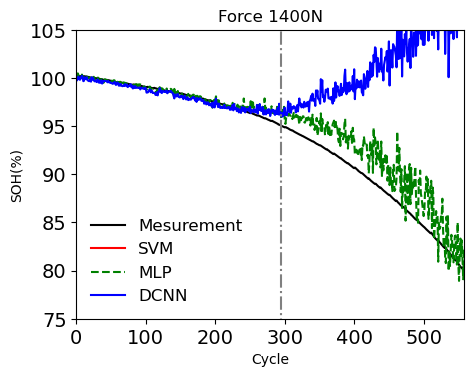

In [38]:
plt.figure(figsize=(5,3.75))
y_2= y_svm
y_4=y_dcnn
y_3=y_mlp
x= np.arange(1, len(y) + 1)
y_soh=y*100
plt.plot(x,y_soh,'k-',label='Mesurement')
plt.plot(x,y_2,'r-',label='SVM')
plt.plot(x,y_3*100,'g--',label='MLP')
plt.plot(x,y_4*100,'b-',label='DCNN')

plt.title("Force 1400N")
plt.xlabel("Cycle")
plt.ylabel("SOH(%)")
plt.xlim([0,len(x)])
plt.ylim(75,105)
plt.axvline(295,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='lower left',frameon=False,fontsize=12)
plt.show()
